(gp_latent)=
# Gaussian Processes: Latent Variable Implementation

:::{post} Sept 28, 2022
:tags: gaussian processes, time series
:category: reference, intermediate
:author: Bill Engels
:::

The {class}`gp.Latent <pymc.gp.Latent>` class is a direct implementation of a Gaussian process without approximation.  Given a mean and covariance function, we can place a prior on the function $f(x)$,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

It is called "Latent" because the GP itself is included in the model as a latent variable, it is not marginalized out as is the case with {class}`gp.Marginal <pymc.gp.Marginal>`.  Unlike `gp.Latent`, you won't find samples from the GP posterior in the trace with `gp.Marginal`.  This is the most direct implementation of a GP because it doesn't assume a particular likelihood function or structure in the data or in the covariance matrix.

## The `.prior` method

The `prior` method adds a multivariate normal prior distribution to the PyMC model over the vector of GP function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}_x$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  By default, PyMC reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This improves sampling by reducing covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

For more information on this reparameterization, see the section on [drawing values from a multivariate distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution).

## The `.conditional` method

The conditional method implements the predictive distribution for function values that were not part of the original data set.  This distribution is,

$$
\mathbf{f}_* \mid \mathbf{f} \sim \text{MvNormal} \left(
  \mathbf{m}_* + \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1} \mathbf{f} ,\,
  \mathbf{K}_{**} - \mathbf{K}_{*x}\mathbf{K}_{xx}^{-1}\mathbf{K}_{x*} \right)
$$

Using the same `gp` object we defined above, we can construct a random variable with this
distribution by,

```python
# vector of new X points we want to predict the function at
X_star = np.linspace(0, 2, 100)[:, None]

with latent_gp_model:
    f_star = gp.conditional("f_star", X_star)
```

## Example 1: Regression with Student-T distributed noise

The following is an example showing how to specify a simple model with a GP prior using the {class}`gp.Latent` class.  We use a GP to generate the data so we can verify that the inference we perform is correct.  Note that the likelihood is not normal, but IID Student-T.  For a more efficient implementation when the likelihood is Gaussian, use {class}`gp.Marginal`.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

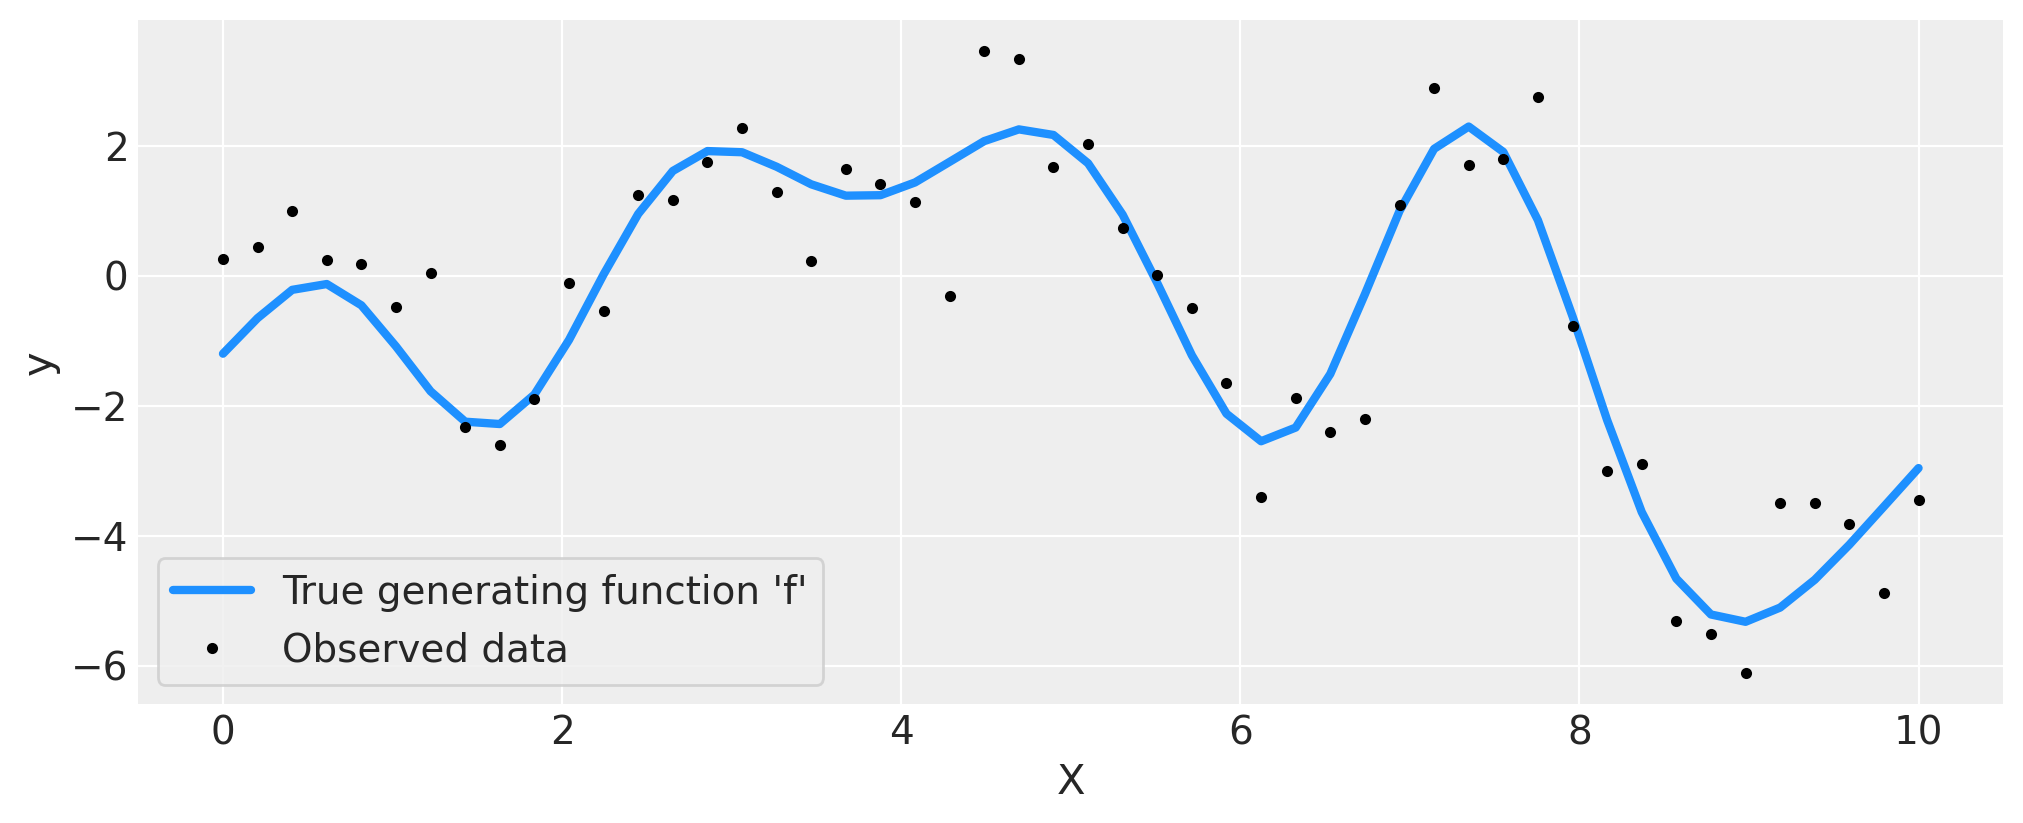

In [3]:
n = 50  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 4.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of Theano
f_true = pm.draw(pm.MvNormal.dist(mu=mean_func(X), cov=cov_func(X)), 1, random_seed=rng)

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
sigma_true = 1.0
nu_true = 5.0
y = f_true + sigma_true * rng.normal(size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend(frameon=True);

The data above shows the observations, marked with black dots, of the unknown function $f(x)$ that has been corrupted by noise.  The true function is in blue.

### Coding the model in PyMC

Here's the model in PyMC.  We use an informative {class}`pm.Gamma(alpha=2, beta=1)` prior over the lengthscale parameter, and weakly informative {class}`pm.HalfNormal(sigma=5)` priors over the covariance function scale, and noise scale.  A `pm.Gamma(2, 0.5)` prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  For more information on choosing priors in Gaussian process models, check out some of [recommendations by the Stan folks](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#priors-for-gaussian-processes).

In [4]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    sigma = pm.HalfNormal("sigma", sigma=2.0)
    nu = 1 + pm.Gamma(
        "nu", alpha=2, beta=0.1
    )  # add one because student t is undefined for degrees of freedom less than one
    y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

    idata = pm.sample(1000, tune=1000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, f_rotated_, sigma, nu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 166 seconds.


In [5]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(idata)[["eta", "ell", "sigma", "f_rotated_"]].to_array() > 1.03).values
)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")

No Rhat values above 1.03, ✓


### Results

The joint posterior of the two covariance function hyperparameters is plotted below in the left panel.  In the right panel is the joint posterior of the standard deviation of the noise, and the degrees of freedom parameter of the likelihood.  The light blue lines show the true values that were used to draw the function from the GP.

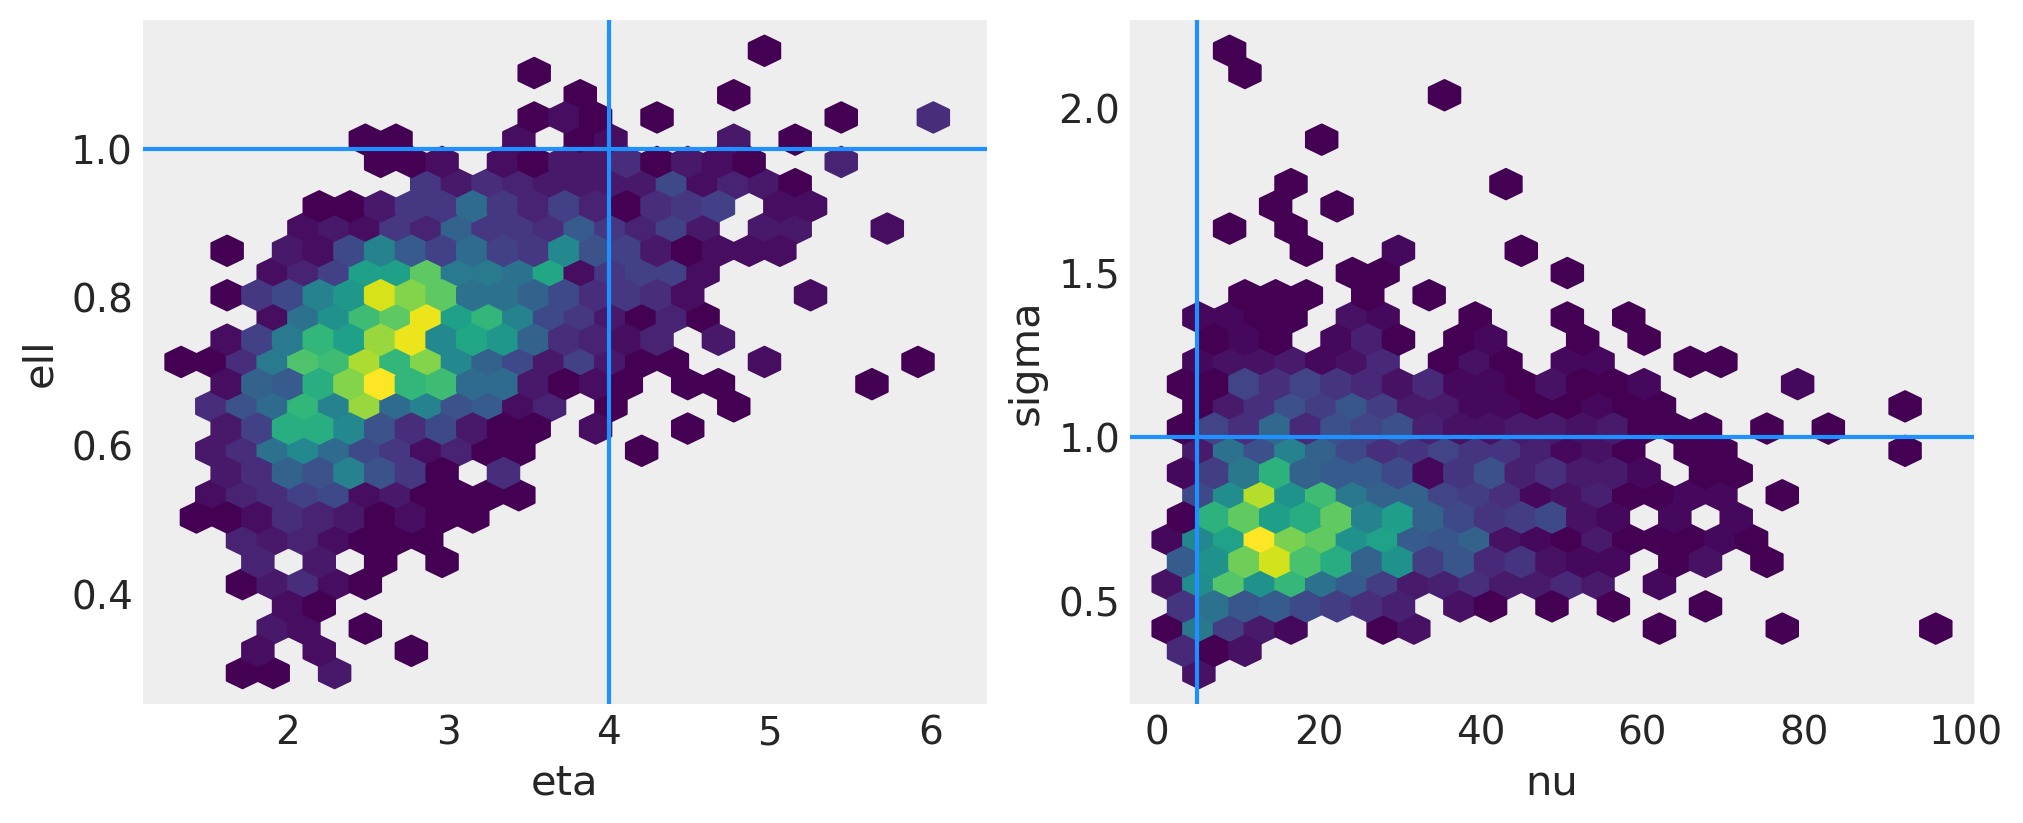

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

# plot eta vs ell
az.plot_pair(
    idata,
    var_names=["eta", "ell"],
    kind=["hexbin"],
    ax=axs[0],
    gridsize=25,
    divergences=True,
)
axs[0].axvline(x=eta_true, color="dodgerblue")
axs[0].axhline(y=ell_true, color="dodgerblue")

# plot nu vs sigma
az.plot_pair(
    idata,
    var_names=["nu", "sigma"],
    kind=["hexbin"],
    ax=axs[1],
    gridsize=25,
    divergences=True,
)

axs[1].axvline(x=nu_true, color="dodgerblue")
axs[1].axhline(y=sigma_true, color="dodgerblue");

In [7]:
f_post = az.extract(idata, var_names="f").transpose("sample", ...)
f_post

<xarray.DataArray 'f' (sample: 2000, f_dim_0: 50)>
array([[ 0.64008709,  0.94209893,  1.11681861, ..., -3.14846949,
        -3.43622962, -3.48706844],
       [ 0.03578305,  0.29277887,  0.22166355, ..., -4.45368382,
        -3.83578716, -2.84530219],
       [-0.04876302,  0.7643869 ,  1.16841321, ..., -3.65840279,
        -3.65683457, -3.92456987],
       ...,
       [ 0.05666861, -0.08209873, -0.04085385, ..., -4.62932099,
        -4.74716237, -5.0141712 ],
       [-0.14021816, -0.14858439, -0.03066233, ..., -2.95586227,
        -2.95585788, -3.26657057],
       [ 0.47357499,  0.70264025,  0.62407442, ..., -4.82028376,
        -4.37349967, -3.9267968 ]])
Coordinates:
  * f_dim_0  (f_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

Below is the posterior of the GP,

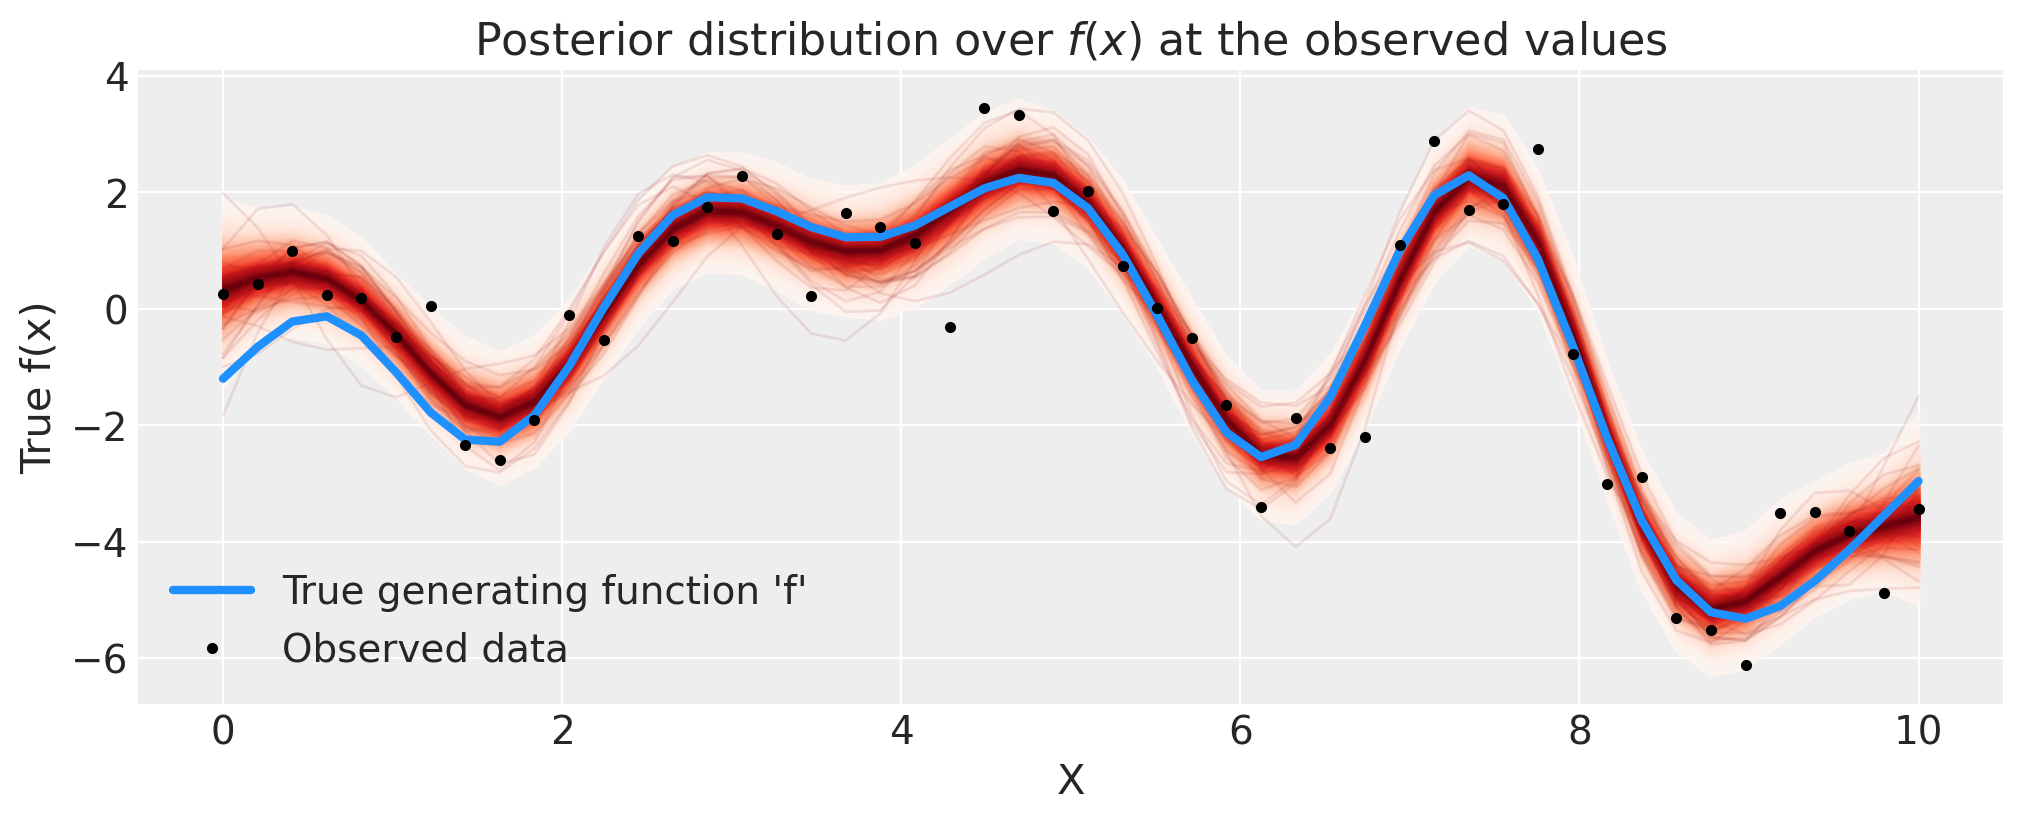

In [8]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_post = az.extract(idata, var_names="f").transpose("sample", ...)
plot_gp_dist(ax, f_post, X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit, and the uncertainty caused by the additive noise.  The result also doesn't over fit due to outliers from the Student-T noise model.

### Prediction using `.conditional`

Next, we extend the model by adding the conditional distribution so we can predict at new $x$ locations.  Lets see how the extrapolation looks out to higher $x$.  To do this, we extend our `model` with the `conditional` distribution of the GP.  Then, we can sample from it using the `trace` and the `sample_posterior_predictive` function.  This is similar to how Stan uses its `generated quantities {...}` block.  We could have included `gp.conditional` in the model *before* we did the NUTS sampling, but it is more efficient to separate these steps.

In [9]:
n_new = 200
X_new = np.linspace(-4, 14, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new, jitter=1e-4)

# Sample from the GP conditional distribution
with model:
    ppc = pm.sample_posterior_predictive(idata.posterior, var_names=["f_pred"])
    idata.extend(ppc)

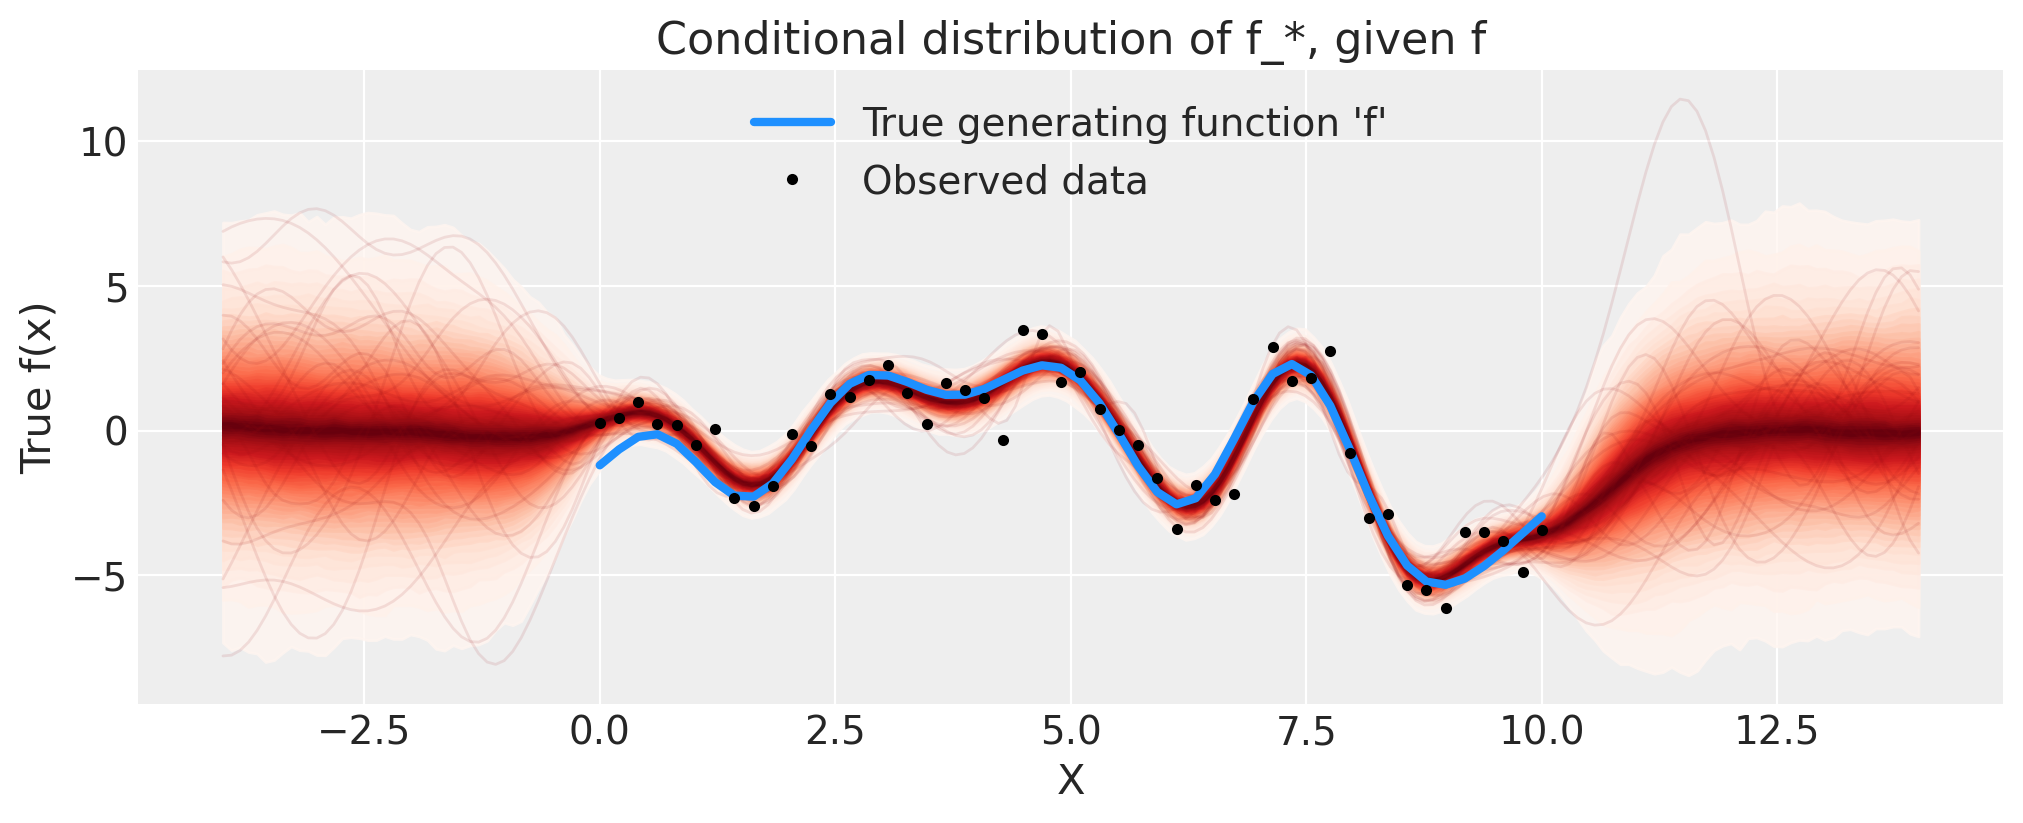

In [10]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred = az.extract(idata.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred, X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();

## Example 2: Classification

First we use a GP to generate some data that follows a Bernoulli distribution, where $p$, the probability of a one instead of a zero is a function of $x$.  I reset the seed and added more fake data points, because it can be difficult for the model to discern variations around 0.5 with few observations.

In [11]:
# reset the random seed for the new example
RANDOM_SEED = 8888
rng = np.random.default_rng(RANDOM_SEED)

# number of data points
n = 300

# x locations
x = np.linspace(0, 10, n)

# true covariance
ell_true = 0.5
eta_true = 1.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)
K = cov_func(x[:, None]).eval()

# zero mean function
mean = np.zeros(n)

# sample from the gp prior
f_true = pm.draw(pm.MvNormal.dist(mu=mean, cov=K), 1, random_seed=rng)

# Sample the GP through the likelihood
y = pm.Bernoulli.dist(p=pm.math.invlogit(f_true)).eval()

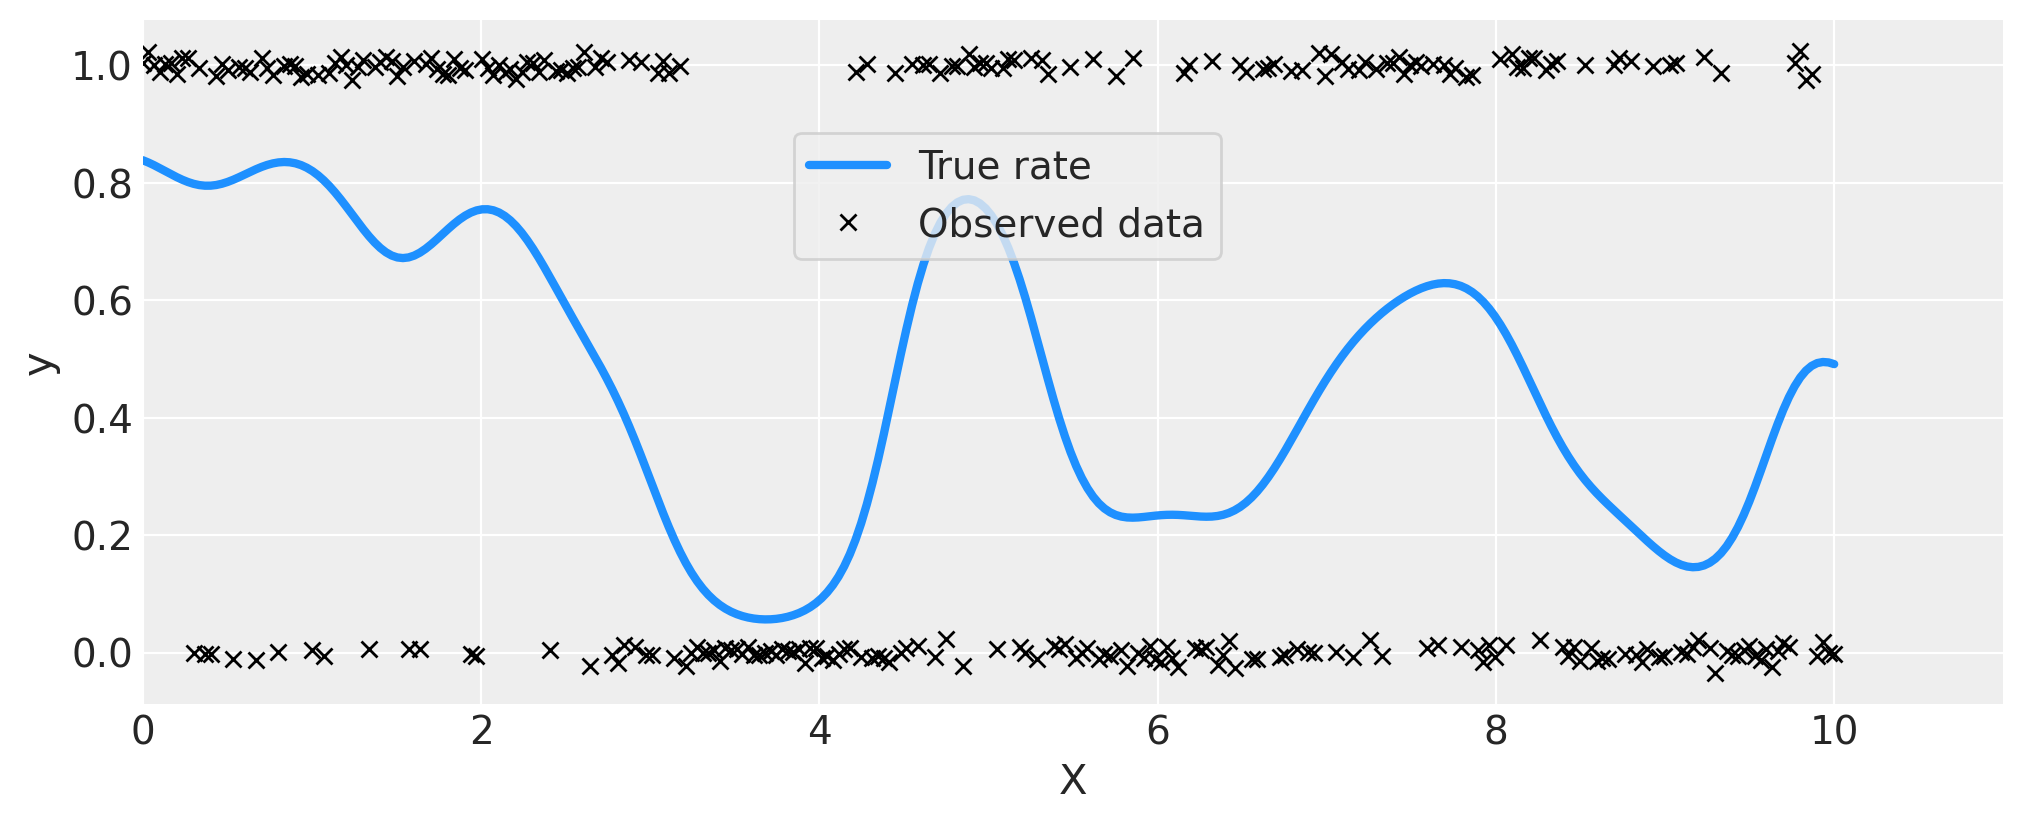

In [12]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

ax.plot(x, pm.math.invlogit(f_true).eval(), "dodgerblue", lw=3, label="True rate")
# add some noise to y to make the points in the plot more visible
ax.plot(x, y + np.random.randn(n) * 0.01, "kx", ms=6, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_xlim([0, 11])
plt.legend(loc=(0.35, 0.65), frameon=True);

In [16]:
with pm.Model() as model:
    ell = pm.InverseGamma("ell", mu=1.0, sigma=0.5)
    eta = pm.Exponential("eta", lam=1.0)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)

    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x[:, None])

    # logit link and Bernoulli likelihood
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)

    idata = pm.sample(1000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, f_rotated_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 771 seconds.


In [17]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(np.sum(az.rhat(idata)[["eta", "ell", "f_rotated_"]].to_array() > 1.03).values)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")

No Rhat values above 1.03, ✓


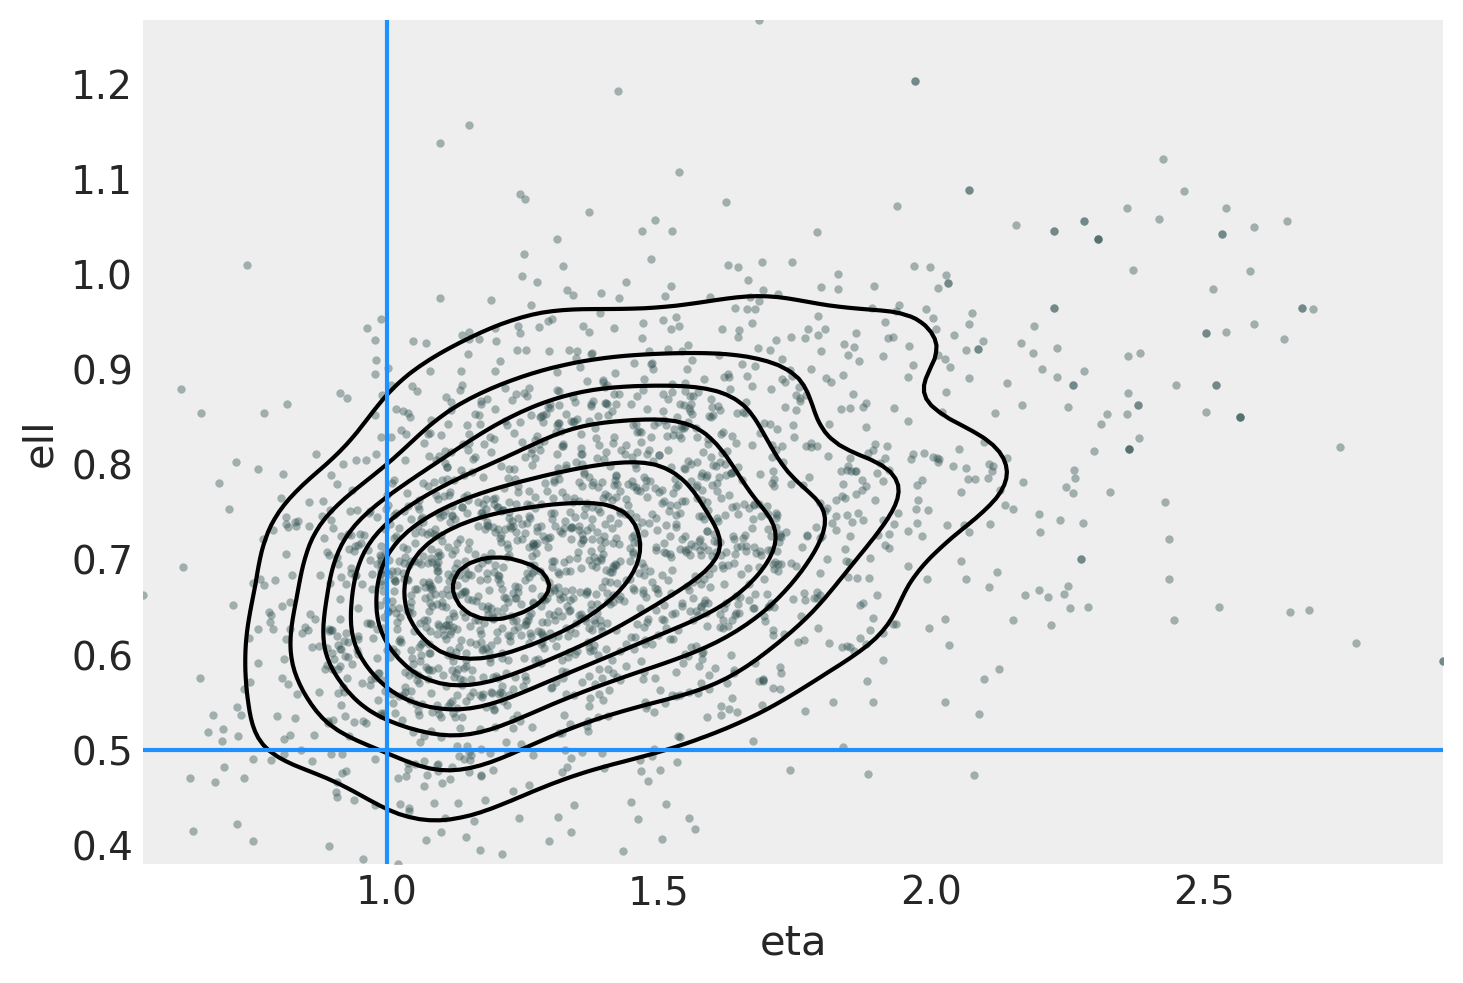

In [18]:
ax = az.plot_pair(
    idata,
    var_names=["eta", "ell"],
    kind=["kde", "scatter"],
    scatter_kwargs={"color": "darkslategray", "alpha": 0.4},
    gridsize=25,
    divergences=True,
)

ax.axvline(x=eta_true, color="dodgerblue")
ax.axhline(y=ell_true, color="dodgerblue");

In [19]:
n_pred = 200
X_new = np.linspace(0, 12, n_pred)[:, None]

with model:
    f_pred = gp.conditional("f_pred", X_new, jitter=1e-4)
    p_pred = pm.Deterministic("p_pred", pm.math.invlogit(f_pred))

with model:
    ppc = pm.sample_posterior_predictive(idata.posterior, var_names=["f_pred", "p_pred"])
    idata.extend(ppc)

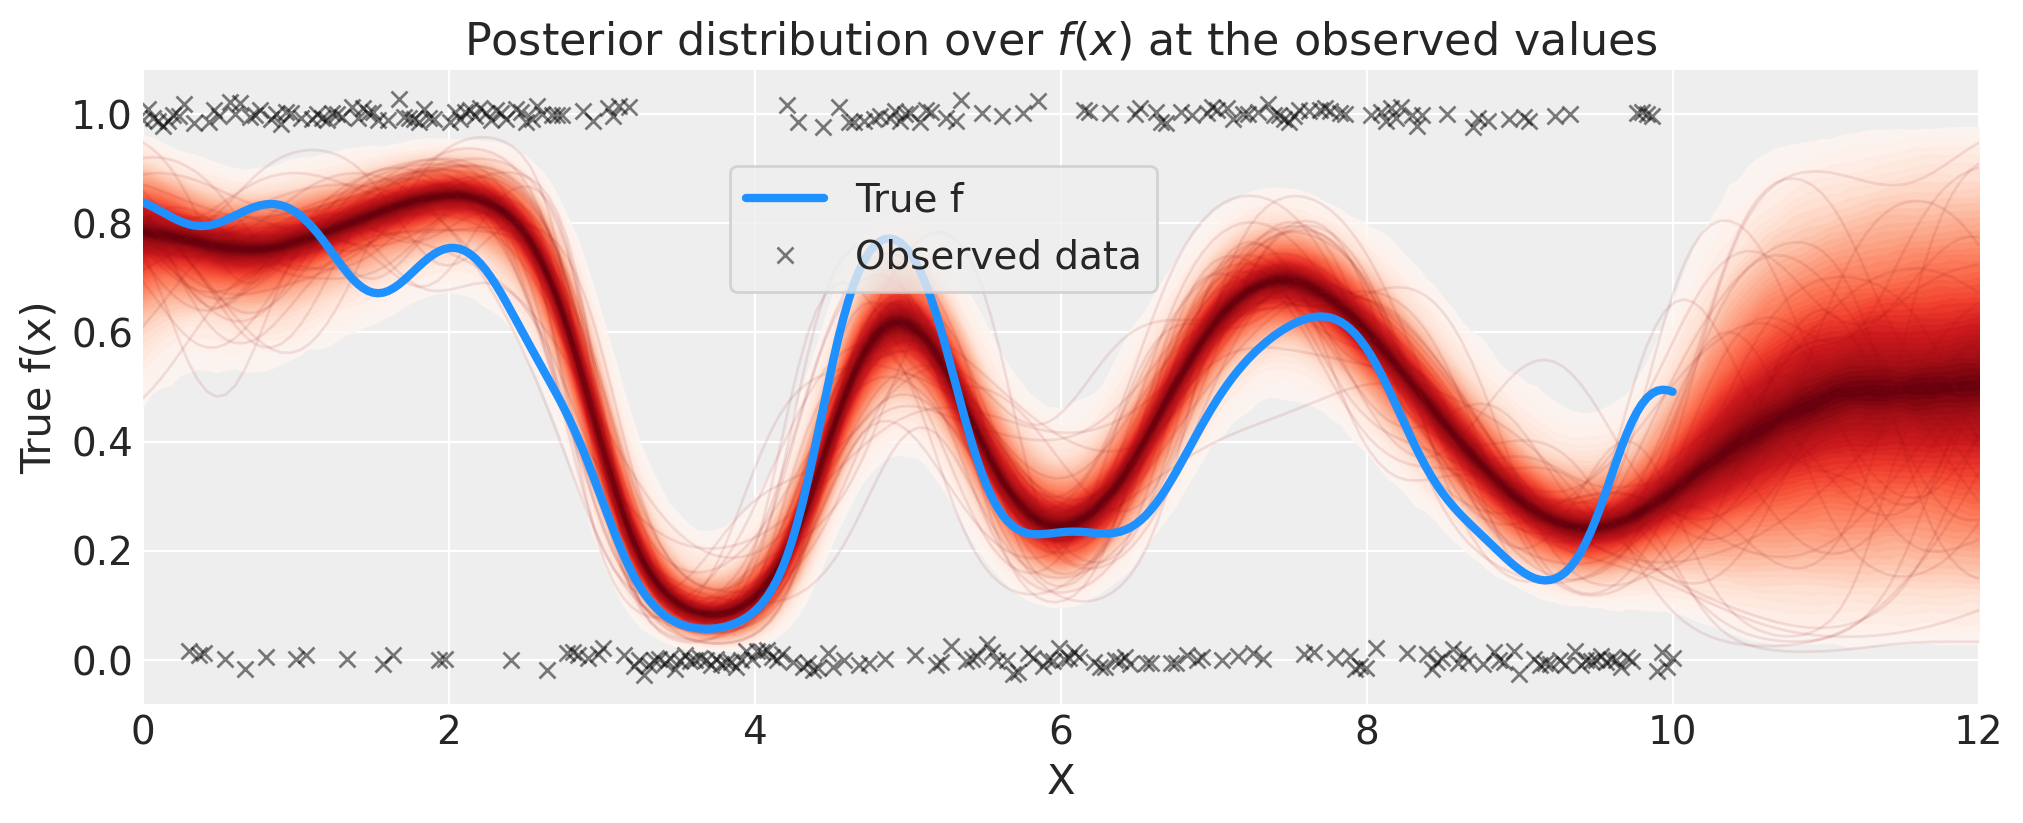

In [20]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
p_pred = az.extract(idata.posterior_predictive, var_names="p_pred").transpose("sample", ...)
plot_gp_dist(ax, p_pred, X_new)

# plot the data (with some jitter) and the true latent function
plt.plot(x, pm.math.invlogit(f_true).eval(), "dodgerblue", lw=3, label="True f")
plt.plot(
    x,
    y + np.random.randn(y.shape[0]) * 0.01,
    "kx",
    ms=6,
    alpha=0.5,
    label="Observed data",
)

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.xlim([0, 12])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend(loc=(0.32, 0.65), frameon=True);

## Authors

* Created by [Bill Engels](https://github.com/bwengals) in 2017 ([pymc#1674](https://github.com/pymc-devs/pymc/pull/1674))
* Reexecuted by [Colin Caroll](https://github.com/ColCarroll) in 2019 ([pymc#3397](https://github.com/pymc-devs/pymc/pull/3397))
* Updated for V4 by Bill Engels in September 2022 ([pymc-examples#237](https://github.com/pymc-devs/pymc-examples/pull/237))

## Watermark

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Wed Sep 28 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

pytensor: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

numpy     : 1.23.2
matplotlib: 3.5.3
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:54) [Clang 13.0.1 ]
pymc      : 4.0.0
arviz     : 0.13.0.dev0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::